In [52]:
# pip install --upgrade pip setuptools wheel


In [53]:
# !pip install -U layoutparser

In [54]:
# !pip install torch torchvision torchaudio


In [55]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


In [56]:
# !pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'

In [57]:
# !pip install layoutparser[ocr]     

In [58]:
# !git clone https://github.com/Layout-Parser/layout-parser.git

In [ ]:
from langchain_openai import ChatOpenAI
import os
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
model = ChatOpenAI(model='gpt-4o')



data = {"Statement_Consolidated_finanacial_results_for_all_months": {
        "Quarter ended 31 December 2024": {
            "Revenue from operations": 16175.71,
            "Other income": 1301.15,
            "Total income": 17476.86,
            "Cost of construction and development": 6272.52,
            "Changes in inventories of work-in-progress and finished properties": 1275.2,
            "Employee benefit expense": 2743.89,
            "Finance costs": 874.35,
            "Depreciation and amortisation expenses": 312.6,
            "Other expenses": 3596.12,
            "Total expenses": 12524.2,
            "Profit/loss before tax and share of profit/loss of joint ventures": 4952.66,
            "Share of profit/loss of joint ventures, net": 11.2,
            "Profit/loss before tax": 4941.42,
            "Current tax": 277.46,
            "Deferred tax": 411.9,
            "Profit/loss for the period/year": 4252.06,
            "Other comprehensive income/loss": 473.84,
            "Total comprehensive income/loss for the period/year, net of tax": 4725.9
        },
}}



structure = {
    "Standalone_financial_results_for_all_months": "Standalone_financial_results_for_all_months",
    "Balance_sheet": "Balance_sheet_are_not_present",
    "Cash_flow_statements": "Cash_flow_statements_are_not_present",
    "Statement_Consolidated_finanacial_results_for_all_months": "Statement_Consolidated_finanacial_results_for_all_months_are_not_present"
}

model = ChatOpenAI(model='gpt-4o')

In [60]:
model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'stop', 'logprobs': None}, id='run-6bd0c3a6-e010-4094-b7ce-80c6d9104b1d-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [62]:
import cv2
from PIL import Image
from pdf2image import convert_from_path
import numpy as np
import sys

from glob import glob
import os
pdf_folder = "/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/task"
all_pdf = glob(os.path.join(pdf_folder,"*.pdf"))

for pdf in all_pdf:

    images = convert_from_path(pdf_path=pdf)
    for i in range(len(images)):
        image = np.array(images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        import layoutparser as lp
        model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65,],
                                        label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
        layout = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
        lp.draw_box(image, layout,)





        text_blocks = lp.Layout([b for b in layout if b.type=="Table"])
        figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])


        text_blocks = lp.Layout([b for b in text_blocks \
                        if not any(b.is_in(b_fig) for b_fig in figure_blocks)])


        h, w = image.shape[:2]

        left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

        left_blocks = text_blocks.filter_by(left_interval, center=True)
        left_blocks.sort(key = lambda b:b.coordinates[1])

        right_blocks = [b for b in text_blocks if b not in left_blocks]
        right_blocks.sort(key = lambda b:b.coordinates[1])

        # And finally combine the two list and add the index
        # according to the order
        text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

        lp.draw_box(image, text_blocks,
                    box_width=3, 
                    show_element_id=True)


        ocr_agent = lp.TesseractAgent(languages='eng') 
            # Initialize the tesseract ocr engine. You might need 
            # to install the OCR components in layoutparser:
            # pip install layoutparser[ocr]
            # 
            # 
            # 


        for block in text_blocks:
            segment_image = (block
                            .pad(left=5, right=10, top=10, bottom=10)
                            .crop_image(image))
                # add padding in each image segment can help
                # improve robustness 
                
            text = ocr_agent.detect(segment_image)
            block.set(text=text, inplace=True)
            


        # for txt in text_blocks.get_texts():
        #     print(txt, end='\n---\n')
        
        result = text_blocks.get_texts()

        with open(f'{os.path.basename(pdf)}.txt','a+') as f:
            f.write(str(result))


KeyboardInterrupt: 

In [63]:
import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
import layoutparser as lp
from glob import glob
import os

# Path to PDF folder
pdf_folder = "/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/task"
all_pdf = glob(os.path.join(pdf_folder, "*.pdf"))

# Load layout detection model
model = lp.Detectron2LayoutModel(
    'lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
    label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"}
)

# Initialize OCR agent
ocr_agent = lp.TesseractAgent(languages='eng')

for pdf in all_pdf:
    images = convert_from_path(pdf_path=pdf)
    for idx, img in enumerate(images):
        image = np.array(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detect layout
        layout = model.detect(image)

        # Extract table blocks
        table_blocks = lp.Layout([b for b in layout if b.type == "Table"])

        results = []
        for block in table_blocks:
            # Preprocess the table image
            segment_image = (block
                             .pad(left=5, right=10, top=10, bottom=10)
                             .crop_image(image))

            # Convert to grayscale and apply threshold
            gray = cv2.cvtColor(segment_image, cv2.COLOR_RGB2GRAY)
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Apply morphological operations to clean the image
            kernel = np.ones((2, 2), np.uint8)
            processed_image = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

            # Perform OCR with Tesseract (configured for tables)
            custom_config = r'--oem 3 --psm 6'
            text = ocr_agent.detect(processed_image, config=custom_config)
            results.append(text)

        # Save results in a structured format (JSON-like)
        output_file = f'{os.path.splitext(os.path.basename(pdf))[0]}_{idx}.txt'
        with open(output_file, 'w') as f:
            for res in results:
                f.write(res.strip() + '\n---\n')


TypeError: TesseractAgent.detect() got an unexpected keyword argument 'config'

In [64]:
import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
import layoutparser as lp
from glob import glob
import os

# Path to PDF folder
pdf_folder = "/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/task"
all_pdf = glob(os.path.join(pdf_folder, "*.pdf"))

# Load layout detection model
model = lp.Detectron2LayoutModel(
    'lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
    label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"}
)

# Initialize OCR agent with custom configuration
ocr_agent = lp.TesseractAgent(languages='eng', oem=3, psm=6)

for pdf in all_pdf:
    images = convert_from_path(pdf_path=pdf)
    for idx, img in enumerate(images):
        image = np.array(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detect layout
        layout = model.detect(image)

        # Extract table blocks
        table_blocks = lp.Layout([b for b in layout if b.type == "Table"])

        results = []
        for block in table_blocks:
            # Preprocess the table image
            segment_image = (block
                             .pad(left=5, right=10, top=10, bottom=10)
                             .crop_image(image))

            # Convert to grayscale and apply threshold
            gray = cv2.cvtColor(segment_image, cv2.COLOR_RGB2GRAY)
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Apply morphological operations to clean the image
            kernel = np.ones((2, 2), np.uint8)
            processed_image = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

            # Perform OCR without additional config (already set during initialization)
            text = ocr_agent.detect(processed_image)
            results.append(text)

        # Save results in a structured format (JSON-like)
        output_file = f'{os.path.splitext(os.path.basename(pdf))[0]}_{idx}.txt'
        with open(output_file, 'w') as f:
            for res in results:
                f.write(res.strip() + '\n---\n')


TypeError: image_to_string() got an unexpected keyword argument 'oem'

In [65]:
import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
import layoutparser as lp
from glob import glob
import pytesseract
import os

# Path to PDF folder
pdf_folder = "/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/task"
all_pdf = glob(os.path.join(pdf_folder, "*.pdf"))

# Load layout detection model
model = lp.Detectron2LayoutModel(
    'lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
    label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"}
)

# Initialize OCR agent without config (we'll pass it manually later)
ocr_agent = lp.TesseractAgent(languages='eng')

for pdf in all_pdf:
    images = convert_from_path(pdf_path=pdf)
    for idx, img in enumerate(images):
        image = np.array(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detect layout
        layout = model.detect(image)

        # Extract table blocks
        table_blocks = lp.Layout([b for b in layout if b.type == "Table"])

        results = []
        for block in table_blocks:
            # Preprocess the table image
            segment_image = (block
                             .pad(left=5, right=10, top=10, bottom=10)
                             .crop_image(image))

            # Convert to grayscale and apply threshold
            gray = cv2.cvtColor(segment_image, cv2.COLOR_RGB2GRAY)
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Apply morphological operations to clean the image
            kernel = np.ones((2, 2), np.uint8)
            processed_image = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

            # Perform OCR using pytesseract with custom config
            custom_config = r'--oem 3 --psm 6'
            text = pytesseract.image_to_string(processed_image, lang='eng', config=custom_config)
            results.append(text)

        # Save results in a structured format
        output_file = f'{os.path.splitext(os.path.basename(pdf))[0]}_{idx}.txt'
        with open(output_file, 'w') as f:
            for res in results:
                f.write(res.strip() + '\n---\n')


In [67]:
import pdfplumber
import pytesseract
from pdf2image import convert_from_path
import cv2
import numpy as np
import os

# Path to PDF folder
pdf_folder = "/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/task"
all_pdf = glob(os.path.join(pdf_folder, "*.pdf"))
# Directly using the uploaded file for now

# Function to preprocess images for OCR
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((2, 2), np.uint8))

for pdf in all_pdf:
    output_file = f"{os.path.splitext(os.path.basename(pdf))[0]}_tables.txt"
    results = []

    # Attempt extraction using pdfplumber first
    with pdfplumber.open(pdf) as pdf_doc:
        for page in pdf_doc.pages:
            tables = page.extract_tables()
            if tables:
                for table in tables:
                    for row in table:
                        results.append(', '.join([str(cell) if cell else "" for cell in row]))
                    results.append('---')

    # If no tables found, fallback to OCR
    if not results:
        images = convert_from_path(pdf)
        for idx, image in enumerate(images):
            image_np = np.array(image)
            processed_image = preprocess_image(image_np)
            
            # Use Tesseract for OCR with table-focused config
            custom_config = r'--oem 3 --psm 6'
            text = pytesseract.image_to_string(processed_image, lang='eng', config=custom_config)
            results.append(text.strip())
            results.append('---')

    # Save results
    with open(output_file, 'w') as f:
        for res in results:
            f.write(res + '\n')

print(f"Extraction completed. Check the output file: {output_file}")


Extraction completed. Check the output file: data (20)_tables.txt


In [ ]:
import cv2
import numpy as np
import pytesseract
from pdf2image import convert_from_path
import pdfplumber
import os





# Preprocess images for OCR
def preprocess_image(image):
    # Convert to grayscale only if the image is in color (3 channels)
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image  # Already grayscale
    
    # Apply thresholding and morphological operations
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((2, 2), np.uint8))
    return processed

# Extract tables using OpenCV by detecting lines
def extract_table_with_opencv(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    horizontal = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((1, 20), np.uint8))
    vertical = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((20, 1), np.uint8))
    mask = horizontal + vertical

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    table_images = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 50 and h > 50:
            table_images.append(image[y:y + h, x:x + w])
    return table_images

for pdf in all_pdf:
    output_file = f"{os.path.splitext(os.path.basename(pdf))[0]}_tables.txt"
    results = []

    # Step 1: Try with pdfplumber first
    with pdfplumber.open(pdf) as pdf_doc:
        for page in pdf_doc.pages:
            tables = page.extract_tables()
            if tables:
                for table in tables:
                    for row in table:
                        results.append(', '.join([str(cell) if cell else "" for cell in row]))
                    results.append('---')

    # Step 2: Fallback to OCR if no tables found
    if not results:
        images = convert_from_path(pdf)
        for image in images:
            np_image = np.array(image)
            processed_image = preprocess_image(np_image)
            table_images = extract_table_with_opencv(processed_image)

            for table_img in table_images:
                custom_config = r'--oem 3 --psm 6'
                text = pytesseract.image_to_string(table_img, config=custom_config)
                results.append(text.strip())
                results.append('---')

    # Save the results
    with open(output_file, 'w') as f:
        for res in results:
            f.write(res + '\n')

print(f"Extraction completed. Check the output file: {output_file}")


Extraction completed. Check the output file: data (20)_tables.txt


In [75]:
import cv2
import numpy as np
import pytesseract
from pdf2image import convert_from_path
import os

# Convert PDF to images with high DPI
def convert_pdf_to_images(pdf_path):
    return convert_from_path(pdf_path, dpi=300)

# Preprocess images for better OCR
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Denoising and adaptive thresholding
    denoised = cv2.fastNlMeansDenoising(gray, h=30)
    _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations to remove noise
    kernel = np.ones((1, 1), np.uint8)
    processed = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    return processed

# Skew correction
def correct_skew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return corrected

# Perform OCR on the table image
def extract_text_from_image(image):
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(image, config=custom_config)
    return text.strip()


pdf_path = "/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/task/data (30).pdf"

images = convert_pdf_to_images(pdf_path)

results = []

for idx, image in enumerate(images):
    np_image = np.array(image)
    
    # Preprocess image
    processed_image = preprocess_image(np_image)
    
    # Correct skew
    processed_image = correct_skew(processed_image)
    
    # Extract text via OCR
    text = extract_text_from_image(processed_image)
    results.append(text)
    results.append('---')

# Save the results
output_file = f"{os.path.splitext(os.path.basename(pdf_path))[0]}_ocr_results.txt"
with open(output_file, 'w') as f:
    for res in results:
        f.write(res + '\n')

print(f"OCR extraction completed. Check the output file: {output_file}")


OCR extraction completed. Check the output file: data (30)_ocr_results.txt


In [73]:
import cv2
import numpy as np
from pdf2image import convert_from_path
import pdfplumber
import pytesseract
import os

# Convert PDF to images with high DPI
def convert_pdf_to_images(pdf_path):
    return convert_from_path(pdf_path, dpi=300)

# Preprocess images for better OCR
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

# Visualize detected tables
def visualize_tables(image, tables):
    for table in tables:
        x, y, w, h = table
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.imshow('Detected Tables', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Attempt to extract tables using OpenCV
def detect_tables(image):
    processed = preprocess_image(image)
    horizontal = cv2.morphologyEx(processed, cv2.MORPH_OPEN, np.ones((1, 20), np.uint8))
    vertical = cv2.morphologyEx(processed, cv2.MORPH_OPEN, np.ones((20, 1), np.uint8))
    mask = horizontal + vertical
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    tables = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 1000]
    return tables


images = convert_pdf_to_images("/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/task/data (30).pdf")

for idx, image in enumerate(images):
    np_image = np.array(image)
    tables = detect_tables(np_image)
    if tables:
        print(f"Page {idx+1}: {len(tables)} table(s) detected.")
        visualize_tables(np_image.copy(), tables)
    else:
        print(f"Page {idx+1}: No tables detected.")



Page 1: 1 table(s) detected.
Page 2: 1 table(s) detected.
Page 3: 1 table(s) detected.
Page 4: 1 table(s) detected.
Page 5: 1 table(s) detected.
Page 6: 1 table(s) detected.
Page 7: 1 table(s) detected.
Page 8: 2 table(s) detected.


In [51]:
all_extracted_txt = glob(os.path.join("./task","*.txt"))
all_extracted_txt
import json

for txt in all_extracted_txt:
    with open(txt) as f:
        scanned_text = f.read()

        input_str = (
    f"Extract financial statements from the provided text, including: STANDALONE, CONSOLIDATED, Balance Sheet, and Cash Flow. "
    f"Use the exact structure and format as shown in this example: {data}. "
    f"Ensure that:\n"
    f"- All values are positive.\n"
    f"- If a statement is not present, mark it as '<statement_name>_are_not_present'.\n"
    f"- Use precise key names like 'Employee benefit expense' instead of variations.\n"
    f"- Do not include markdown formatting, newlines, or unnecessary characters.\n"
    f"- Follow the data types (float for numeric values, string for text).\n"
    f"- Ignore extra text that does not belong to the financial statements.\n"
    f"Here is the input text: {scanned_text}."
)


            
        result_json  = model.invoke(str(input_str))
        with open(f"{os.path.basename(txt)}.json","+a") as f:
            json.dump(result_json.content,f)






In [42]:
result_json.content

'{"Standalone_financial_results_for_all_months": {"Quarter ended 31 December 2024": {"Revenue from operations": 4466.46, "Other income": 247.6, "Total income": 4714.06, "Cost of materials consumed": 2100.58, "Purchase of stock-in-trade": 214.18, "Changes in inventories of finished goods, work-in-progress": 264.52, "Employees benefits expense": 263.88, "Finance costs": 63.32, "Depreciation and amortisation expense": 79.55, "Job charges": 878.17, "Other expenses": 465.31, "Total expenses": 4329.47, "Profit/loss before tax": 136.99, "Deferred tax": 36.68, "Profit/loss for the period": 100.30, "Other comprehensive income/loss": 0.91, "Total comprehensive income/loss for the period": 100.99}}, "Balance_sheet": "Balance_sheet_are_not_present", "Cash_flow_statements": "Cash_flow_statements_are_not_present", "Statement_Consolidated_finanacial_results_for_all_months": "Statement_Consolidated_finanacial_results_for_all_months_are_not_present"}'

In [37]:
from langchain_openai import ChatOpenAI

In [43]:
import numpy as np

pdf_path = "/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/GenAIbased_Financial_StatementExtraction/Task (1)/task/data (20).pdf"
images = convert_from_path(pdf_path)

# Convert first image from PIL to OpenCV format (BGR)
image = np.array(images[1]) 

In [44]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Convert to PIL format for layoutparser
# image = Image.fromarray(image)

In [45]:
# !pip uninstall pillow
# !pip install pillow==9.5.0


import PIL
print(PIL.__version__)



9.5.0


In [46]:
image.shape

(2200, 1505, 3)

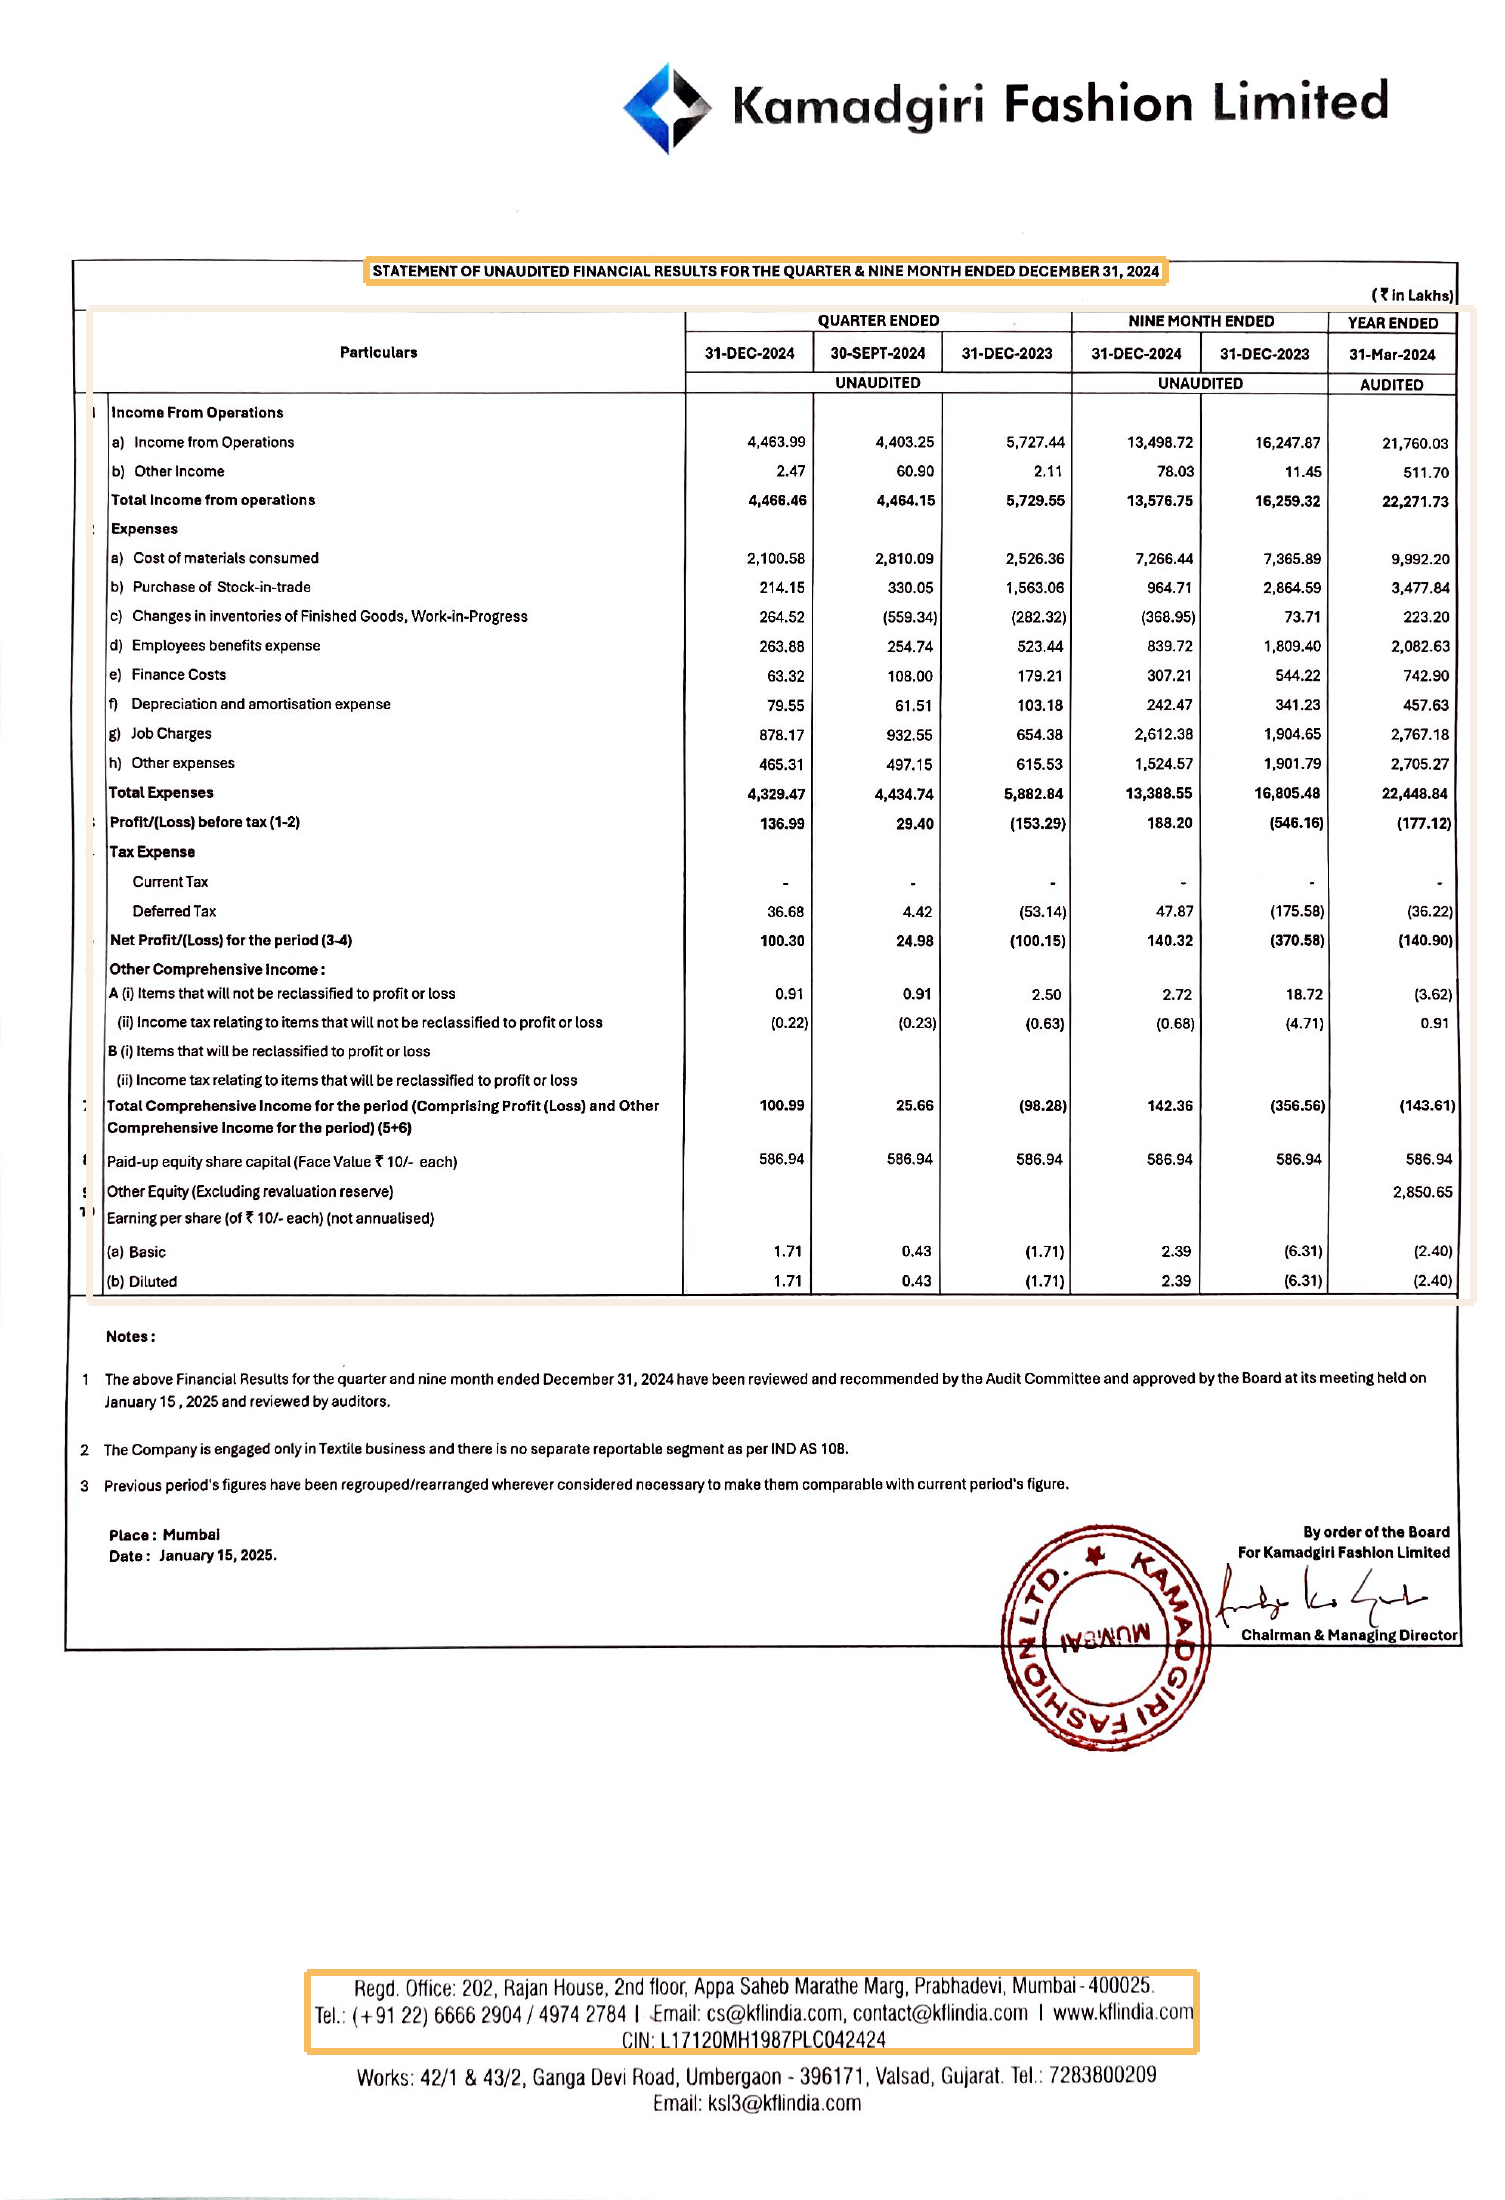

In [47]:
import layoutparser as lp
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65,],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image, layout,)





# model = lp.Detectron2LayoutModel(
#     'lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
#     extra_config=[
#         "MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5,  # Lowered threshold for more detections
#         "MODEL.ROI_HEADS.NMS_THRESH", 0.5,          # Non-Maximum Suppression threshold
#     ],
#     label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"}
# )




In [48]:
# import layoutparser as lp
# from PIL import Image
# import numpy as np
# import cv2

# # Convert the PIL image to OpenCV format
# image = np.array(image)

# # Convert RGB to BGR (OpenCV uses BGR by default)
# image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# # Define the model
# model = lp.Detectron2LayoutModel(
#     'lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
#     extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
#     label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"}
# )

# # Detect layout
# layout = model.detect(image)

# # Draw bounding boxes on the image
# drawn_image = lp.draw_box(image, layout)

# # Convert back to PIL for displaying (if needed)
# drawn_image = Image.fromarray(cv2.cvtColor(drawn_image, cv2.COLOR_BGR2RGB))

# # Display the image using PIL (avoiding OpenCV GUI issues)
# drawn_image.show()


In [49]:
text_blocks = lp.Layout([b for b in layout if b.type=="Table"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=89.4960708618164, y_1=308.1905822753906, x_2=1473.3297119140625, y_2=1302.907470703125), text=None, id=None, type=Table, parent=None, next=None, score=0.9613880515098572)], page_data={})

In [ ]:
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [51]:
figure_blocks

Layout(_blocks=[], page_data={})

In [ ]:

text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [ ]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

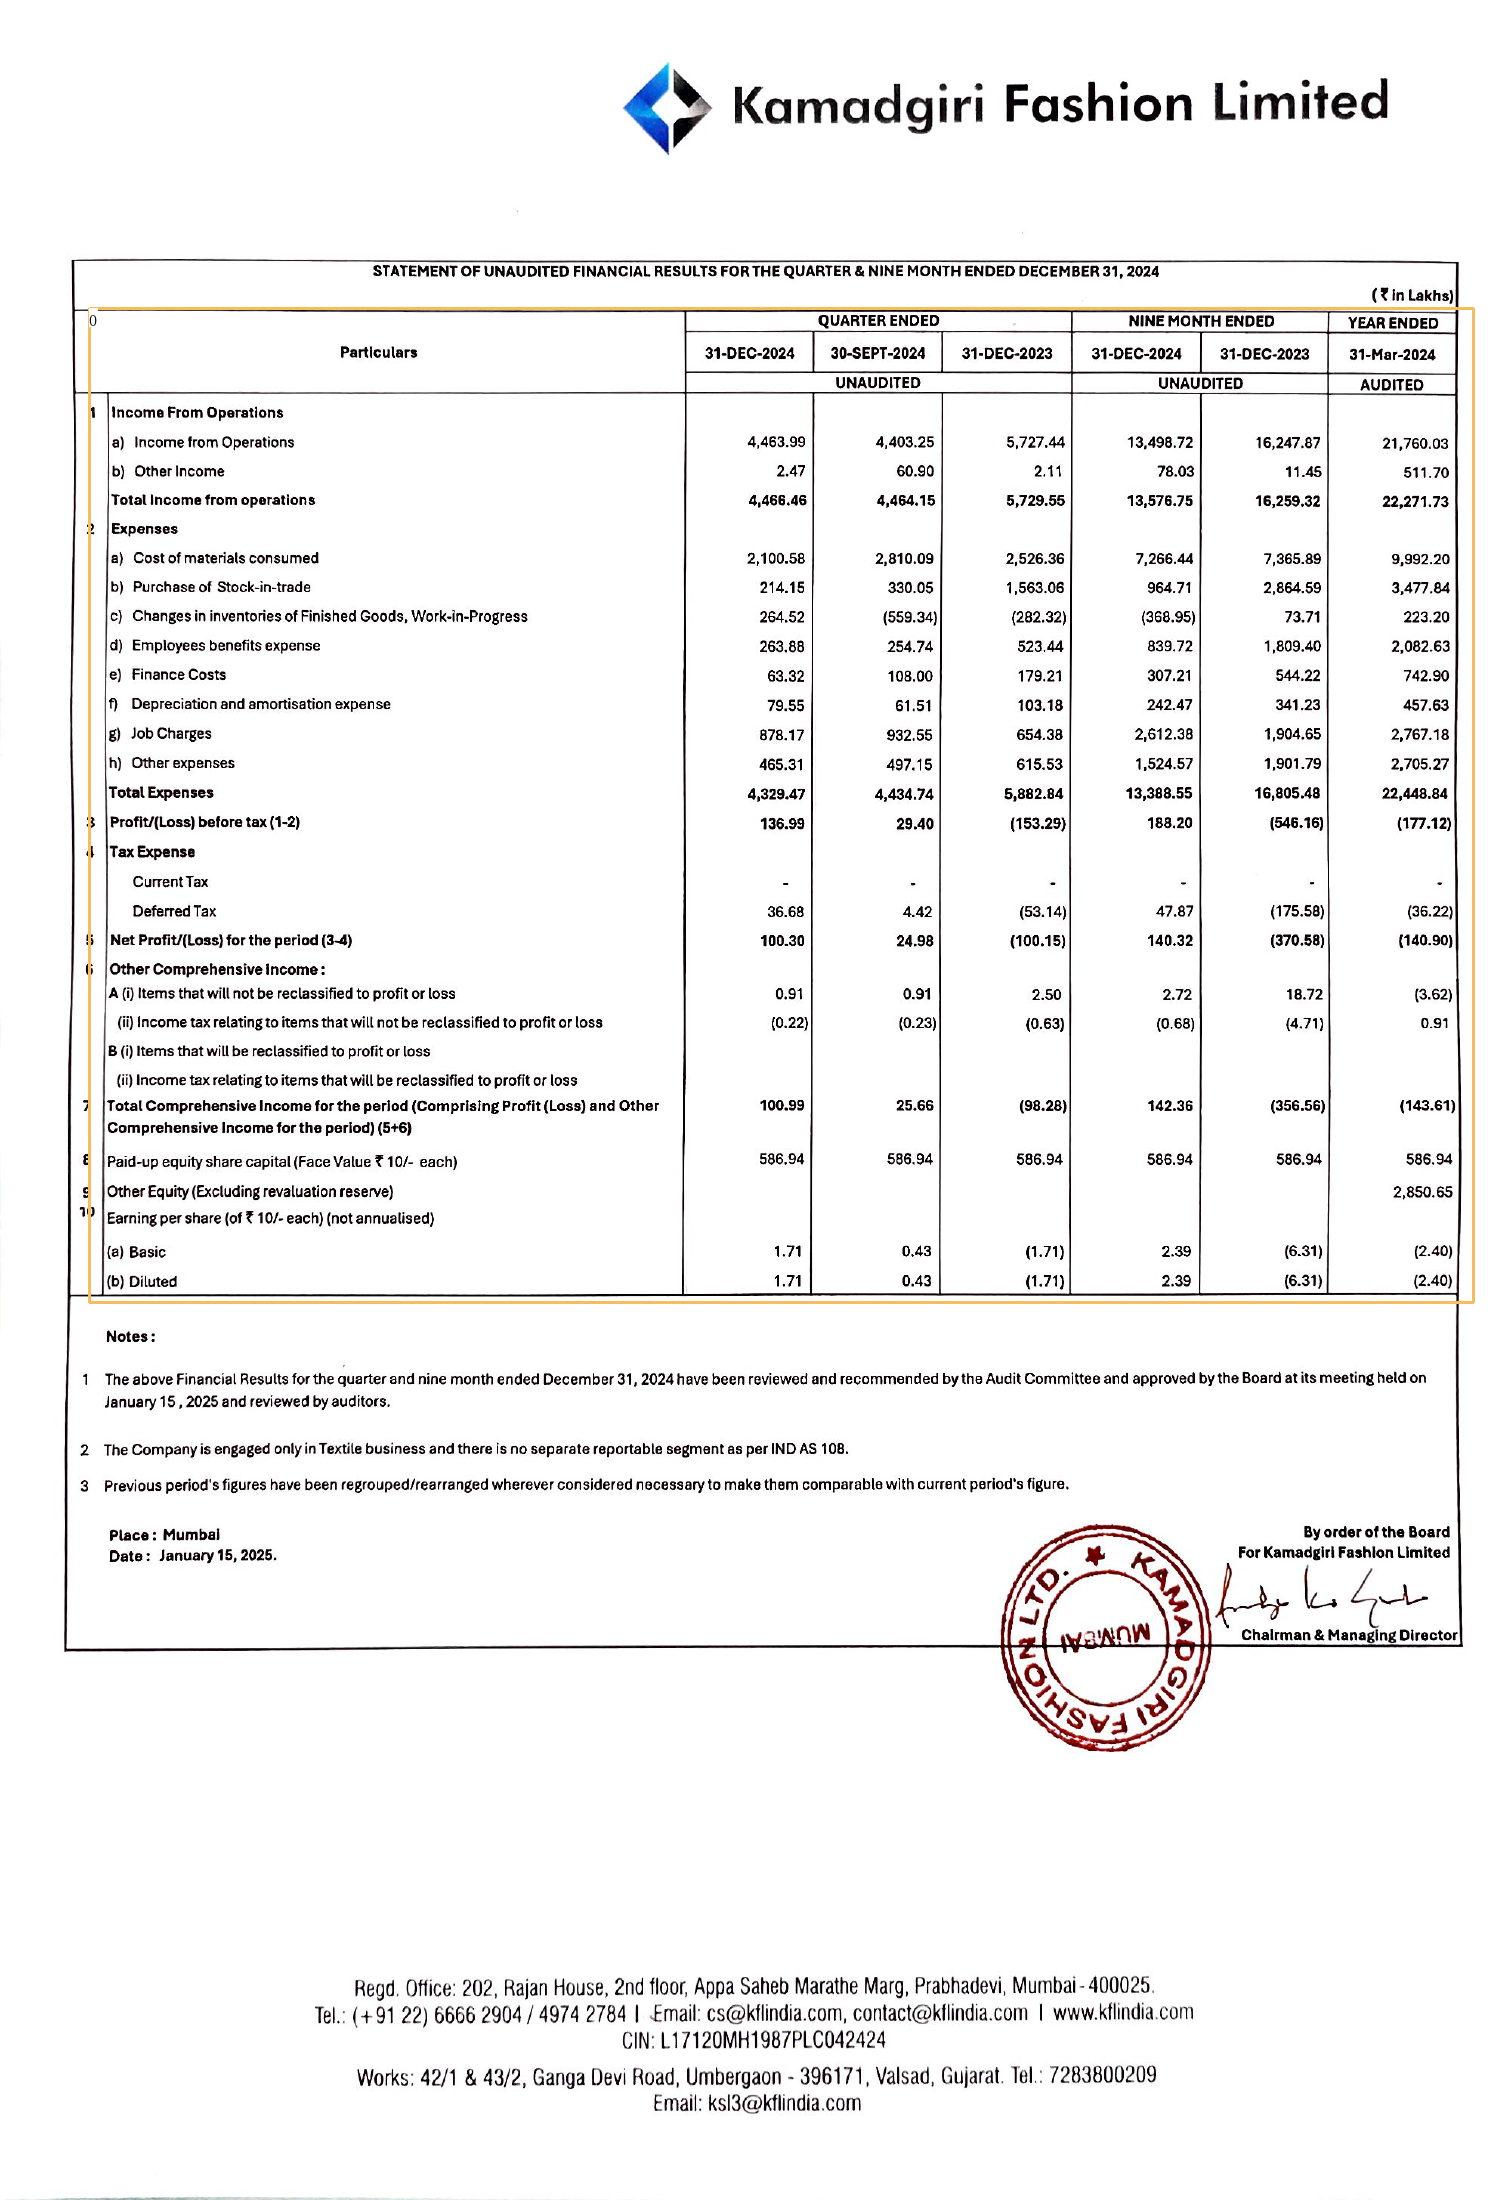

In [ ]:

lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

In [ ]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [ ]:
# !sudo apt install tesseract-ocr





In [ ]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=10, top=10, bottom=10)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [ ]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

‘QUARTER ENDED NINE MONTH ENDED YEAR ENDED
Particulars 31-DEC-2024 | 30-SEPT-2024 | 31-DEC-2023 | 31-DEC-2024 | 31-Dec-2023 | 31-Mar-2024
UNAUDITED UNAUDITED ‘AUDITED
1 Income From Operations
/2) Income trom Operations 4,463.99 4,403.25 5,727.44 13,498.72 16,247.87 21,760.03
lb) Other Income 247 60.90 244 78.03 11.45 511.70
‘Total Income from operations 4,466.46 4,484.15 5,729.55 13,576.75 16,259.32 22,271.73
2 [Expenses
la) Cost of materials consumed 2,100.58 2,810.09 2,526.36 7,266.44 7,365.89 9,992.20
b) Purchase of Stock-in-trade 214.18 330.05 1,563.06 964.71 2,864.59 3,477.84
c) Changes in inventories of Finished Goods, Work-in-Progress 264,52 (559.34) (282.32) (368.95) 73.71 223.20
d) Employees benefits expense 263.88 254.74 523.44 839.72 1,809.40 2,082.63
e) Finance Costs 63.32 108,00 179.21 307.21 844.22 742.90
) Depreciation and amortisation expense 79.55 61.51 103.18 242.47 341.23 457.63
§) Job Charges 878.17 932.55 654.38 2,612.38 1,904.65 2,767.18
h) Other expenses 465.31 4

In [25]:
text_blocks.get_texts()

['LIDATED UNAUDITED FINANCIAL RESULTS FOR THE QUARTER AND NINE MONTHS ENDED 31st DECEMBER , 2024\n\n(Rs. in Lakhs) Except per share data\n\nSTANDALONE CONSOLIDATED.\nQuarter Ended Nine Month Ended [Year Endec ‘Quarter Ended ‘Nine Month Ended _[vear Ended]\nOza] 30.09.2024] 31.12.2023 | 31.12.2024 | 31.12.2023 [31.03.2024 31.12.2024 30.09.2024 31.12.2023 | 31.12.2024]31.12.202\nted | Unaudited | Unaudited | Unaudited | Unaudited | Audited | Unaudited | Unaudited] Unaudited | Unaudited | Unaudited | Audited\n55,646] 21,836 68,383] 65,088] 89,045\n130 an 112 240] 340\n55,776 | _ 21,877 68,495 | 65,328] 89,385\n27210} 26,443} 34,179] 14,233] 15,773] 15,131] 44,839] 42,674] 57,770\n4 9 62 - - 2 - 2 52\n(1,119) (s6a)] 100 (788)} (559) 26] (1,803) (394)) 315\n791 707 666 2,068 2,488] 1,166 1003] 3,138] 2,957] 3,852\n526 474 373 1,472 1,504 787 503] 2,069] 1,512] 1,955\n376 310 226 912 out 644 464] 1,676] 1,317) 1,772\n7} 2,743] 2,358 8,208 9,038] 4,601 3,684] 12,846] 10,522] 14,289\n996| 13,2

In [10]:
for block in text_blocks:
  print(block)

In [27]:
!pip install spacy

In [28]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/457.4 MB 1.1 MB/s eta 0:06:35
^C


In [ ]:
!pip install click

In [ ]:
import spacy
nlp = spacy.load("en_core_web_trf")


ModuleNotFoundError: No module named 'click.shell_completion'

In [ ]:
sentence=["".join(txt) for txt in text_blocks.get_texts()]

In [ ]:
".".join(sentence)  

In [ ]:
doc = nlp(".".join(sentence))
for ent in doc.ents:
  print(ent.text,ent.label_)

In [ ]:
import cv2

# Check if the image loads correctly
image_path = "/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/statement.png"
image = cv2.imread(image_path)

if image is None:
    print(f"Failed to load image from {image_path}")
else:
    print("Image loaded successfully")


Image loaded successfully


In [ ]:

image_path = "/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/statement.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# Now proceed with processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [ ]:
from PIL import Image
import cv2
import numpy as np
import layoutparser as lp

# Load the image using OpenCV
image_path = "/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/statement.png"
image = cv2.imread(image_path)

# Convert from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Preprocessing: Grayscale and thresholding
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
denoised = cv2.medianBlur(thresh, 3)

# Convert to PIL format for layoutparser
image_pil = Image.fromarray(image)

# Load the layout model
model = lp.Detectron2LayoutModel(
    'lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
    label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"}
)

# Detect the layout
layout = model.detect(image_pil)

# Draw detected boxes for visualization (optional)
lp.draw_box(image_pil, layout, box_width=3, show_element_id=True)

# Initialize Tesseract OCR with optimized configuration
ocr_agent = lp.TesseractAgent(languages='eng')

# Extract and process text from each detected block
for block in layout:
    # Padding and cropping (convert PIL to NumPy for processing)
    segment_image = np.array(block.pad(left=15, right=15, top=15, bottom=15).crop_image(image_pil))
    
    # OCR with custom config for structured text
    text = ocr_agent.detect(
        segment_image,
        config='--psm 6 --oem 3'
    )
    block.set(text=text, inplace=True)

# Display the extracted texts
for txt in layout.get_texts():
    print(txt, end='\n---\n')


TypeError: 'Image' object is not subscriptable

In [ ]:
from PIL import Image
import cv2
import numpy as np
import layoutparser as lp

# Load the image using OpenCV
image_path = "/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/statement.png"
image = cv2.imread(image_path)

if image is None:
    raise ValueError(f"Image not found at {image_path}")

# Convert from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to PIL format for layoutparser
image_pil = Image.fromarray(image_rgb)

# Load the layout model
model = lp.Detectron2LayoutModel(
    'lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
    label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"}
)

# Detect the layout
layout = model.detect(image_pil)

# Draw detected boxes for visualization (optional)
lp.draw_box(image_pil, layout, box_width=3, show_element_id=True)

# Initialize Tesseract OCR with optimized configuration
ocr_agent = lp.TesseractAgent(languages='eng')

# Convert image to numpy for cropping
image_np = np.array(image_pil)

# Extract and process text from each detected block
for block in layout:
    # Padding and cropping (use NumPy array image for crop_image)
    segment_image = block.pad(left=15, right=15, top=15, bottom=15).crop_image(image_np)

    # OCR with custom config for structured text
    text = ocr_agent.detect(
        segment_image,
        config='--psm 6 --oem 3'
    )
    block.set(text=text, inplace=True)

# Display the extracted texts
for txt in layout.get_texts():
    print(txt, end='\n---\n')


TypeError: TesseractAgent.detect() got an unexpected keyword argument 'config'

In [77]:
!pip install torch torchvision torchaudio
!pip install opencv-python pytesseract pdf2image
!pip install detectron2 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install matplotlib


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [80]:
import cv2
import numpy as np
import pytesseract
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Load CascadeTabNet Model (Download the model from official source if not already)
model_path = "CascadeTabNet.pth"  # Path to your pre-trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dummy function as placeholder for actual CascadeTabNet detection
def detect_tables_with_cascadetabnet(image):
    # In real implementation, load the model and perform inference here
    # For now, we'll assume the whole image is the table
    return [image]

# Function to preprocess images
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

# Function to perform OCR on table segments
def extract_text_from_image(image):
    custom_config = r'--oem 3 --psm 6'
    return pytesseract.image_to_string(image, config=custom_config).strip()

# Convert PDF to Images
def convert_pdf_to_images(pdf_path):
    return convert_from_path(pdf_path, dpi=300)



for pdf in all_pdf:

    images = convert_pdf_to_images(pdf)

    results = []

    for idx, image in enumerate(images):
        np_image = np.array(image)
        processed_image = preprocess_image(np_image)

        # Detect tables with CascadeTabNet
        detected_tables = detect_tables_with_cascadetabnet(processed_image)

        for table_image in detected_tables:
            text = extract_text_from_image(table_image)
            results.append(text)
            results.append('---')

    # Save the results
    output_file = f"{pdf}_structured_output.txt"
    with open(output_file, 'w') as f:
        for res in results:
            f.write(res + '\n')

    print(f"OCR extraction completed. Check the output file: {output_file}")


OCR extraction completed. Check the output file: /media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/task/data (13).pdf_structured_output.txt
OCR extraction completed. Check the output file: /media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/task/data (4).pdf_structured_output.txt
OCR extraction completed. Check the output file: /media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/task/data (30).pdf_structured_output.txt
OCR extraction completed. Check the output file: /media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/task/data (20).pdf_structured_output.txt


In [81]:
import pytesseract
from pdf2image import convert_from_path
from PIL import Image
import os

# Paths
input_pdf = '/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/task/data (30).pdf'
output_pdf = "converted_text_based.pdf"

# Convert PDF to images
images = convert_from_path(input_pdf, dpi=300)

# Convert images to searchable PDF pages
image_list = []
for i, image in enumerate(images):
    # Convert image to grayscale
    gray_image = image.convert('L')
    
    # Apply OCR and save as PDF
    pdf_bytes = pytesseract.image_to_pdf_or_hocr(gray_image, extension='pdf')
    with open(f"page_{i}.pdf", "wb") as f:
        f.write(pdf_bytes)
    image_list.append(f"page_{i}.pdf")

# Merge individual pages into one PDF
from PyPDF2 import PdfMerger

merger = PdfMerger()
for pdf in image_list:
    merger.append(pdf)

merger.write(output_pdf)
merger.close()

# Clean up temporary files
for temp_pdf in image_list:
    os.remove(temp_pdf)

print(f"Conversion completed. Text-based PDF saved as: {output_pdf}")


ModuleNotFoundError: No module named 'PyPDF2'

In [ ]:
from langchain_openai import ChatOpenAI
import os
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
model = ChatOpenAI(model='gpt-4o')


In [ ]:
import openai
import base64

from langchain_openai import ChatOpenAI


# Convert the image to base64 format
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# Path to your financial image file
image_path = "task/data (20).pdf"  # Replace with your image path

# Send the image to GPT-4o
response = openai.ChatCompletion.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are a financial data extractor."},
        {"role": "user", "content": "Extract the financial table data from this image."}
    ],
    max_tokens=2000,
    temperature=0.0,
    image=[{"data": encode_image(image_path), "type": "base64"}]  # Image in base64
)

# Print the extracted table
print(response['choices'][0]['message']['content'])


APIRemovedInV1: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742


In [14]:
from PyPDF2 import PdfReader
from PIL import Image
import io
import base64
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage

# Set your OpenAI API key

llm = ChatOpenAI(model="gpt-4o")

# Function to extract images from PDF
def extract_images_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    images = []

    for page in reader.pages:
        if '/XObject' in page['/Resources']:
            xObject = page['/Resources']['/XObject'].get_object()
            for obj in xObject:
                if xObject[obj]['/Subtype'] == '/Image':
                    size = (xObject[obj]['/Width'], xObject[obj]['/Height'])
                    data = xObject[obj]._data
                    image = Image.open(io.BytesIO(data))
                    images.append(image)

    return images

# Function to encode image in base64
def encode_image(image):
    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

# Path to your PDF file
pdf_path = "task/data (20).pdf"  # Replace with your PDF path

# Extract images
images = extract_images_from_pdf(pdf_path)

# Send each image to GPT-4o via LangChain
for i, img in enumerate(images):
    base64_image = encode_image(img)

    messages = [
        SystemMessage(content="You are a financial data extractor."),
        HumanMessage(content="Extract the financial table data from this image."),
        HumanMessage(content={"image": base64_image, "type": "base64"})
    ]

    response = llm(messages)

    print(f"--- Table from Image {i + 1} ---")
    print(response.content)


/tmp/ipykernel_201000/2424241857.py:10: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o")


ValidationError: 2 validation errors for HumanMessage
content.str
  Input should be a valid string [type=string_type, input_value={'image': 'iVBORw0KGgoAAA...YII=', 'type': 'base64'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]]
  Input should be a valid list [type=list_type, input_value={'image': 'iVBORw0KGgoAAA...YII=', 'type': 'base64'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/list_type

In [15]:
!pip install PyPDF2
!pip install langchain-community
!pip install pytesseract Pillow


In [ ]:
from PIL import Image
import pytesseract
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# Step 1: Extract Text from Image
image_path = "/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/data (20)/page_1.jpg"  # Path to the extracted table image
image = Image.open(image_path)
extracted_text = pytesseract.image_to_string(image)

# Step 2: Use LangChain with the extracted text
llm = ChatOpenAI(model="gpt-4", temperature=0)

prompt = PromptTemplate(
    input_variables=["data"],
    template="""
    all detail from the table and create json structure:
    example:
    

    Data:
    {data}
    
    """
)

# Create the chain
chain = LLMChain(llm=llm, prompt=prompt)

# Use the extracted text
result = chain.run(extracted_text)
print(result)


ValueError: Missing some input keys: {'data'}

In [23]:
extracted_text

"» Kamadgiri Fashion Limited\n\nSTATEMENT OF UNAUDITED FINANCIAL RESULTS FOR THE QUARTER & NINE MONTH ENDED DECEMBER 31, 2024\n\n(Zin Lakhs)\nQUARTER ENDED\nUNAUDITED [UNAUDITED sd AUDITED CO\n1 |Income From Operations\na) Income from Operations 4,463.99 4,403.25 5,727.44 13,498.72 16,247.87 21,760.03\nb) Other Income 2.47 60.90 2.11 78.03 11.45 511.70\nTotal Income from operations 4,466.46 4,464.15 5,729.55 13,576.75 16,259.32 22,271.73\n2 |Expenses\na) Cost of materials consumed 2,100.58 2,810.09 2,526.36 7,266.44 7,365.89 9,992.20\nb) Purchase of Stock-in-trade 214.15 330.05 1,563.06 964.71 2,864.59 3,477.84\nc) Changes in inventories of Finished Goods, Work-in-Progress 264,52 (559.34) (282.32) (368.95) 73.71 223.20\nd) Employees benefits expense 263.88 254.74 523.44 839.72 1,809.40 2,082.63\ne) Finance Costs 63.32 108.00 179.21 307.21 544.22 742.90\nf) Depreciation and amortisation expense 79,55 61,51 103.18 242.47 341.23 457.63\n8) Job Charges 878.17 932.55 654.38 2,612.38 1,904.6

In [26]:
import cv2
def extract_text_from_image(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Preprocessing for better OCR
    gray = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)[1]

    # OCR
    text = pytesseract.image_to_string(gray, config='--psm 6')
    return text


image_path = "/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/ExtractTheImageData/data (20)/page_1.jpg"  # Path to the extracted table image

raw_text = extract_text_from_image(image_path)


In [27]:
raw_text

"a iri Fashion Limite\nKamadgiri Fashion Limited\nWwW\n(Tin Lakhs)\nrn Fre [sera [aor | ataer | ste [ee |\npo NAUITED OO auieD ED\n1 |!ncome From Operations\n@) Incorne from Operations 4,463.99 4,403.25 5,727.44 13,498.72 16,247.87 21,760.03\nb) Other income 2.47 60.90 2.11 78.03 11.45 511.70\nTotal Income trom operations 4,466.46 4,464.15 5,729.55 13,576.75 16,259.32 22,271.73\n2 |Expenses\na} Cost of materials consumed 2,100.58 2,810.09 2,526.36 7,266.44 7,365.89 9,992.20\nb) Purchase of Stock-in-trade 214,15 330.05 1,563.06 964.71 2,864.59 3,477.84\nc} Changes in inventories of Finished Goods, Work-in-Progress 264.52 (559.34) (282.32) (368.95) 73.71 223,20\nd) Employees benefits expense 263.88 254.74 523.44 839.72 1,809.40 2,082.63\ne) Finance Costs 63.32 108.00 179.21 307.21 $44.22 742.90\nf) Depreciation and amortisation expense 79,55 61.51 103.18 242.47 341.23 457.63\n8} Job Charges 878.17 932.55 654.38 2,612.38 1,904.65 2,767.18\nh) Other expenses 465.31 497.15 615.53 1,524.57 1